Run prediction on multiple bright field 2D images

In [1]:
from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image
#from cytodata_aics.model_utils import save_predictions_classifier

20-Oct-22 04:04:49 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
df = pd.read_parquet("s3://allencell-hipsc-cytodata/hackathon_manifest_17oct2022.parquet")
df.set_index(df['CellId'].astype(int), inplace=True)
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 77


Encode cell stage as integer

In [3]:
#From Chapter 5
#loading library, making path for
from serotiny.transforms.dataframe.transforms import split_dataframe
Path("/home/aicsuser/serotiny_data/").mkdir(parents=True, exist_ok=True)
# Sample n cells per group
n = 2000 # number of cells per mitotic class
cells_to_include=[]
for name, group in df.groupby('cell_stage'):
    sampled_group = group.sample(min([n,len(group)]))
    cells_to_include.append(sampled_group)
df_mitocells = pd.concat(cells_to_include).reset_index(drop=True)
# Discarding all the M6M7_single cells
df_mitocells = df_mitocells.drop(df_mitocells[df_mitocells['cell_stage']=='M6M7_single'].index)
df_mitocells['cell_stage_encoded'] = pd.factorize(df_mitocells['cell_stage'])[0]
# Add the train, test and validate split
df_mitocells = split_dataframe(dataframe=df_mitocells, train_frac=0.7, val_frac=0.2, return_splits=False)
df_mitocells.to_csv("/home/aicsuser/serotiny_data/tra_mitocells.csv")
print(f"Number of cells: {len(df_mitocells)}")
print(f"Number of columns: {len(df_mitocells.columns)}")

Number of cells: 8179
Number of columns: 79


In [4]:
class_count = df_mitocells["cell_stage"].unique()
print(class_count)

# Check if encoding cell stage is mapping correctly
#stages = df_mitocells[['cell_stage', 'cell_stage_encoded']].head()
#print(stages)

['M0' 'M1M2' 'M3' 'M4M5' 'M6M7_complete']


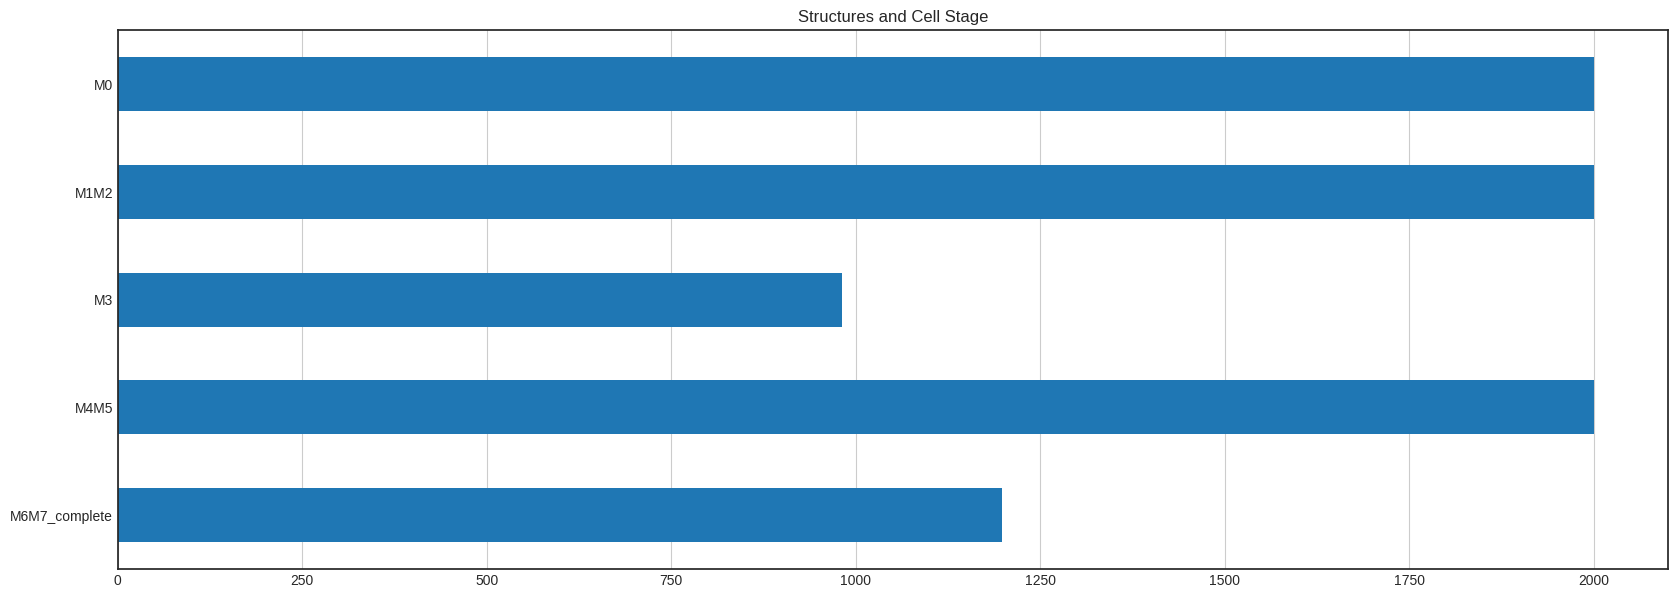

cell_stage
M0               2000
M1M2             2000
M3                981
M4M5             2000
M6M7_complete    1198
dtype: int64


In [5]:
# The bar plot counting number of cell in our dataset
%matplotlib inline
plt.style.use('seaborn-v0_8-white')   #print(plt.style.available)
# Code from Chapter 4 to make a bar plot
table = pd.pivot_table(df_mitocells, index="cell_stage", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Cell Stage")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()
print(table)

In [6]:
# pointing to LOCAL config files
import os
os.chdir("/home/aicsuser/eyeballExpress/cytodata-hackathon-base")

In [7]:
# create unique name based on time
from datetime import datetime
# util to avoid referring to the same run unintentionally
now_str = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")

In [ ]:
run_name = f"tra_multiBf_{now_str()}"
print(run_name)
!serotiny train \
    model=classifier_2d_multiBF \
    data=dataloader_2d_multiBF \
    mlflow.experiment_name=eyeballExpress \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=30

tra_multiBf_20221020_042533
[2022-10-20 04:25:36,887][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-10-20 04:25:36,888][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-10-20 04:25:39,335][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
[2022-10-20 04:25:39,369][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True, used: True
[2022-10-20 04:25:39,369][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2022-10-20 04:25:39,369][pytorch_lightning.utilities.rank_zero][INFO] - IPU available: False, using: 0 IPUs
[2022-10-20 04:25:39,369][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2022-10-20 04:25:39,370][serotiny.ml_ops.ml_ops][INFO] - Instantiating model
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
 